In [215]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData3/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [216]:
data = [
'f001_S2000001_1.mat',
'f001_S2000001_5.mat',
'f001_S2000001_10.mat',
'f001_S2000001_15.mat',
'f001_S2000001_20.mat',
'f001_S2000001_25.mat',
'f001_S2000001_30.mat',
'f001_S2000001_35.mat',
'f001_S2000001_40.mat',
'f001_S2000001_45.mat',
'f001_S2000001_50.mat',
'f001_S2000001_55.mat',
'f001_S2000001_60.mat',
'f002_S2000001_1.mat',
'f002_S2000001_5.mat',
'f002_S2000001_10.mat',
'f002_S2000001_15.mat',
'f002_S2000001_20.mat',
'f002_S2000001_25.mat',
'f002_S2000001_30.mat',
'f002_S2000001_35.mat',
'f002_S2000001_40.mat',
'f002_S2000001_45.mat',
'f002_S2000001_50.mat',
'f002_S2000001_55.mat',
'f002_S2000001_60.mat',
'f003_S2000001_1.mat',
'f003_S2000001_5.mat',
'f003_S2000001_10.mat',
'f003_S2000001_15.mat',
'f003_S2000001_20.mat',
'f003_S2000001_25.mat',
'f003_S2000001_30.mat',
'f003_S2000001_35.mat',
'f003_S2000001_40.mat',
'f003_S2000001_45.mat',
'f003_S2000001_50.mat',
'f003_S2000001_55.mat',
'f003_S2000001_60.mat',
'f004_S2000001_1.mat',
'f004_S2000001_5.mat',
'f004_S2000001_10.mat',
'f004_S2000001_15.mat',
'f004_S2000001_20.mat',
'f004_S2000001_25.mat',
'f004_S2000001_30.mat',
'f004_S2000001_35.mat',
'f004_S2000001_40.mat',
'f004_S2000001_45.mat',
'f004_S2000001_50.mat',
'f004_S2000001_55.mat',
'f004_S2000001_60.mat',
'f005_S2000001_1.mat',
'f005_S2000001_5.mat',
'f005_S2000001_10.mat',
'f005_S2000001_15.mat',
'f005_S2000001_20.mat',
'f005_S2000001_25.mat',
'f005_S2000001_30.mat',
'f005_S2000001_35.mat',
'f005_S2000001_40.mat',
'f005_S2000001_45.mat',
'f005_S2000001_50.mat',
'f005_S2000001_55.mat',
'f005_S2000001_60.mat'
]

In [217]:
DATA = []
d = 50
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(len(data)):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    DATA.append(np.dot(ds1, ds))
print (len(DATA), DATA[0].shape)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

65 (3, 50)


Text(0.5, 0, 'z')

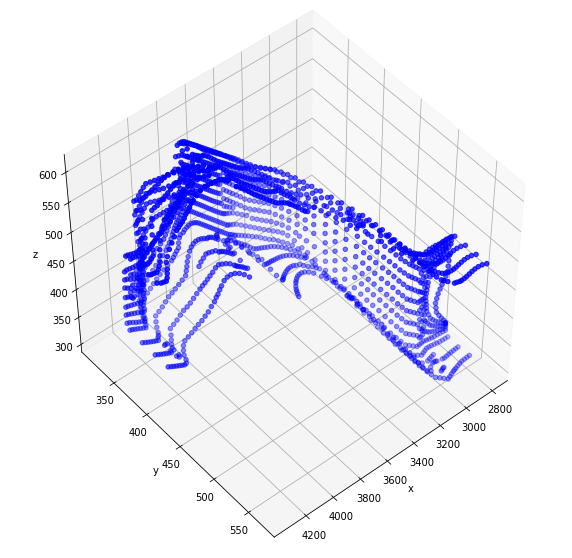

In [218]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

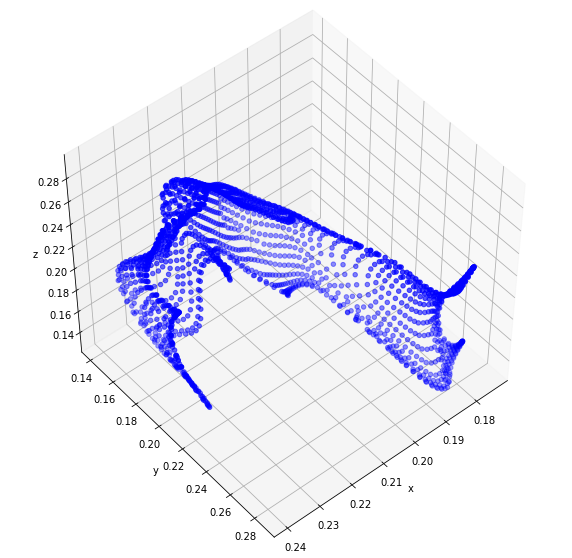

In [219]:
xyz= np.dot(DATA[65-5], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

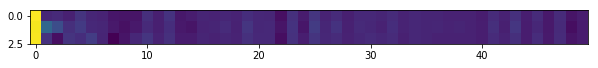

In [220]:
plt.figure(figsize=(10, 10)); 
plt.imshow(DATA[65-5])

In [221]:
vae = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=d, stateful = False) #default stateful = False

vae.fit(DATA[0:65-13], learning_rate=0.001, batch_size = 10, num_epochs = 400, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.00874
Epoch   11   Loss 0.00499
Epoch   21   Loss 0.00294
Epoch   31   Loss 0.00175
Epoch   41   Loss 0.00138
Epoch   51   Loss 0.00112
Epoch   61   Loss 0.00090
Epoch   71   Loss 0.00072
Epoch   81   Loss 0.00055
Epoch   91   Loss 0.00040
Epoch  101   Loss 0.00030
Epoch  111   Loss 0.00020
Epoch  121   Loss 0.00013
Epoch  131   Loss 0.00009
Epoch  141   Loss 0.00007
Epoch  151   Loss 0.00005
Epoch  161   Loss 0.00003
Epoch  171   Loss 0.00003
Epoch  181   Loss 0.00002
Epoch  191   Loss 0.00002
Epoch  201   Loss 0.00001
Epoch  211   Loss 0.00001
Epoch  221   Loss 0.00001
Epoch  231   Loss 0.00001
Epoch  241   Loss 0.00001
Epoch  251   Loss 0.00001
Epoch  261   Loss 0.00001
Epoch  271   Loss 0.00001
Epoch  281   Loss 0.00001
Epoch  291   Loss 0.00001
Epoch  301   Loss 0.00001
Epoch  311   Loss 0.00001
Epoch  321   Loss 0.00001
Epoch  331   Loss 0.00001
Epoch  341   Loss 0.00001
Epoch  351   Loss 0.00001
Epoch  361   Loss 0.00001
Epoch  371   Loss 0.00

In [222]:
x_reconstructed, recons_error = vae.reconstruct(DATA[65-13:], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA) #latent space representation

Text(0.5, 0, 'latent 3')

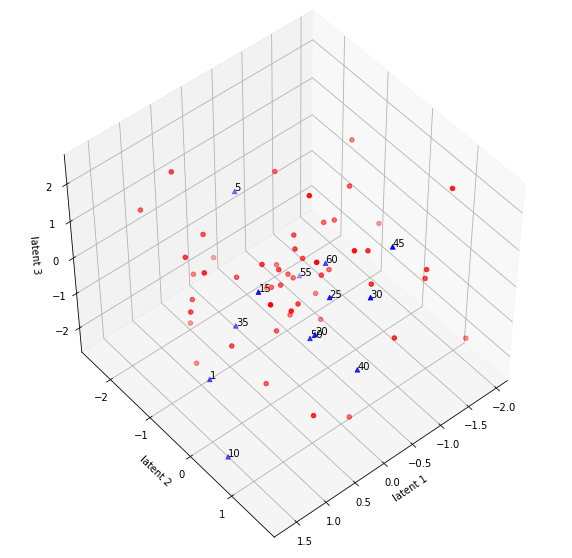

In [225]:
fig = plt.figure(figsize=(10, 10))
c = ['r', 'b']
m = ['o', '^']
label = ['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:65-13, 0], x_reduced[0:65-13, 1], x_reduced[0:65-13, 2], c=c[0], marker=m[0])
ax.scatter(x_reduced[65-13:, 0], x_reduced[65-13:, 1], x_reduced[65-13:, 2], c=c[1], marker=m[1])
ii = 0
for i in range(65-13, 65):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=10, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

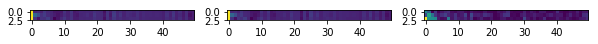

In [226]:
plt.figure(figsize=(10, 30)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[13-5])
plt.subplot(1,3,2); plt.imshow(DATA[65-5])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[13-1] - DATA[65-5]))

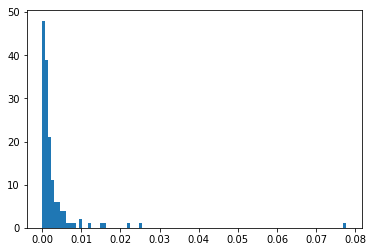

In [227]:
_,_,_ = plt.hist(np.abs(x_reconstructed[13-1] - DATA[65-1]).reshape((3*d)), bins=100)

(3, 1714)


Text(0.5, 0, 'z')

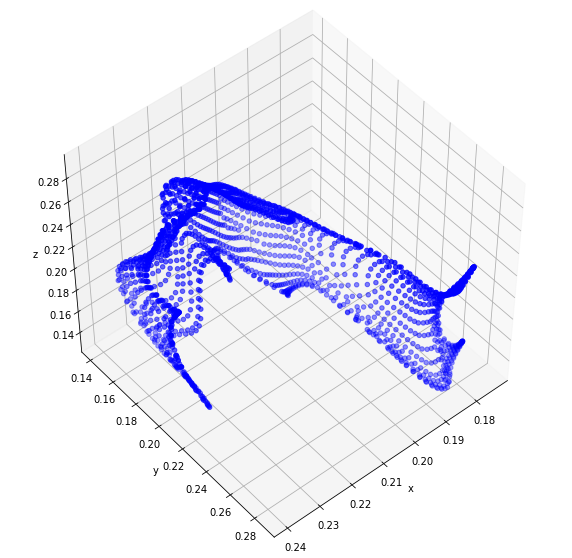

In [228]:
xyz= np.dot(DATA[65-5], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

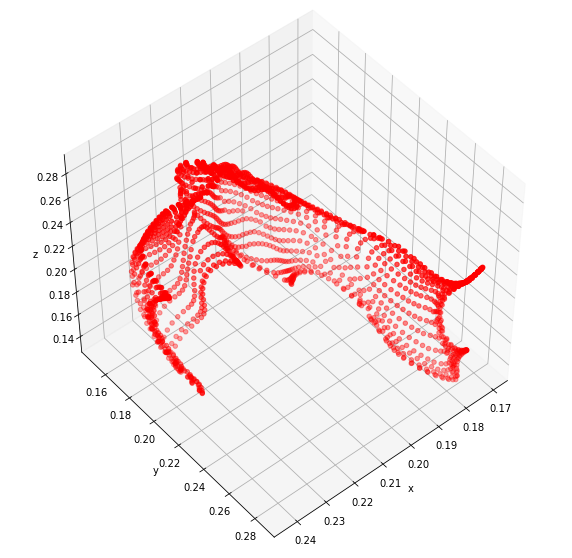

In [229]:
xyz_reconstructed = np.dot(x_reconstructed[13-5], np.linalg.pinv(ds))
print (xyz_reconstructed.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['^', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=c[1], marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')